# What is Convolution?

Convolution is an operation in signal and image processing;
it operates on two signals (1D) or two images (2D). 

Think of one as the input signal and the other, the kernel as a filter on the input producing an output.

the input data, which the filter is shining over called the receptive field. the green part.  let’s take the first position the filter is in for example.  It would be the top 3 rows. 

As the filter is sliding along window dimension, or convolving, around the input signal, it is multiplying the values in the filter with the values of the input or signal ( element wise multiplications). These multiplications are all summed up produces a single number. 

repeat this process for every location on the input. (Next step would be moving the filter to the down by 1 unit. Every unique location on the input produces a number. 

# What is the kernel doing?

After sliding the filter over all the locations, you will find out that what you’re left with is a window size - kernel + 1 of numbers, which  called as activation map or feature map. 
 

the filters are feature identifiers and the output is the feature map of the input.

timeseries: Timeseries data with time increasing down the rows (the leading dimension/axis).
window_size: The number of previous timeseries values to use to predict the next. lag or lookback

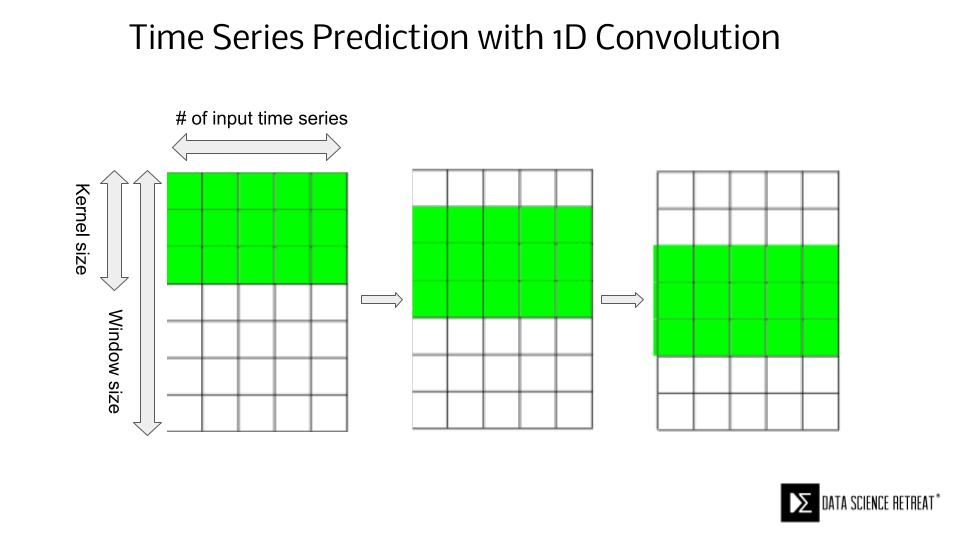

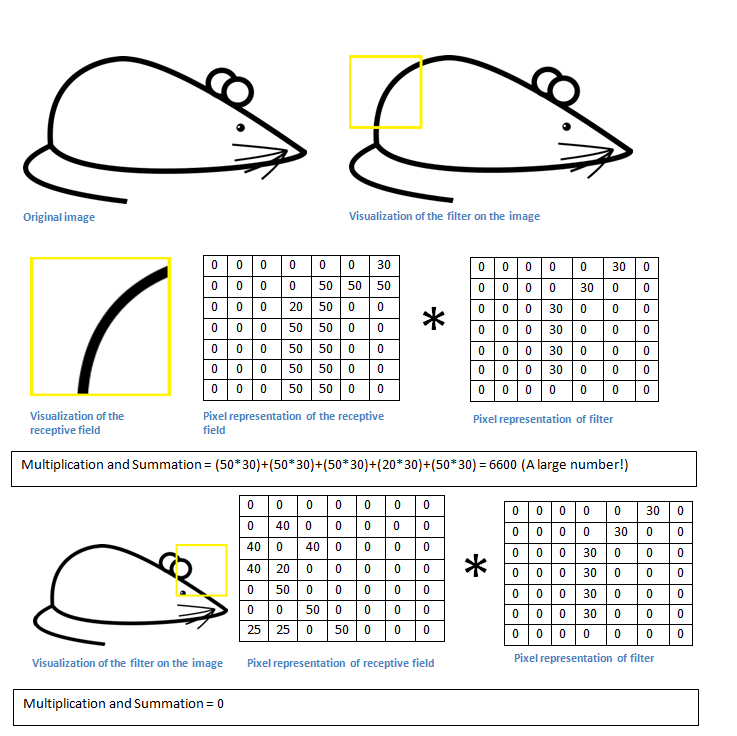

In [2]:
#a curve detector: simple example

Remember, this single number after multiplication is just representative of the filter exactly where it stands on during convolving!

So the result of this sliding is named as feature map. and the filters are feature identifiers.

When saying features, things like straight edges, simple colors, and curves

# using Keras to implement a 1D convolutional neural network (CNN) for timeseries prediction.

predicting the next value in a timeseries given a fixed-size lookback window of previous values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import mean_absolute_error

tour = pd.read_csv('./numerai_dataset_99/numerai_tournament_data.csv')
train = pd.read_csv('./numerai_dataset_99/numerai_training_data.csv')

timeseries=pd.concat([train,tour])

feature_cols = [f for f in timeseries.columns if "feature" in f]
timeseries=timeseries[feature_cols].values

window_size=30
STEP=1

#   Make input features and prediction targets from a `timeseries` for use in CNN

For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`,
      usually the value(s) predicted to come after the last value in that input instance, i.e., the next value
      in the sequence. 

In [4]:
X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
y = timeseries[window_size:]

In [5]:
X.shape,y.shape,timeseries.shape

((636936, 30, 50), (636936, 50), (636966, 50))

In [6]:
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


Using TensorFlow backend.


In [20]:
def timeseries_regressor(filter_length=5, nb_filter=4):
    #opt = Nadam(lr=0.002)   
    
    nb_series = timeseries.shape[1]
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Conv1D( filters=nb_filter, kernel_size=filter_length,
                      activation='relu', input_shape=(window_size, nb_series)),
        #BatchNormalization(),
       # LeakyReLU(),
        #Dropout(0.8),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        #Max pooling reduces dimensions, forcing the network to discriminate important features.
        Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'),
        #BatchNormalization(),
        #LeakyReLU(),
        #Dropout(0.8),
        
        Flatten(),
        Dense(nb_series, activation='linear'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model
#Mean Absolute Error (MAE):
#MAE measures the average magnitude of the errors in a set of predictions, 
#without considering their direction. 
#It’s the average over the test sample of the absolute differences 
#between prediction and actual observation where all individual differences have equal weight.
#MSE is a quadratic scoring rule that also measures the average magnitude of the error.
# It’s the square root of the average of squared differences between prediction and actual observation.

Note: RMSE. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are undesirable. 

rmse if you want give importance to outliers

mae if you do not give much importance to outliers and as you think they are mistakes

In [ ]:
#kernel_size = [5, 7, 9, 11,17] 7
#n_filter = [15,20,50] 15
#batch=[32,64,128] 32

In [7]:
model = timeseries_regressor(7,15)
model.load_weights("weights.best_cnn_50w_7f_15nf_32b_20e.hdf5")

In [8]:
model = timeseries_regressor(7,15)
filepath="./weights.best_cnn_30w_7f_15nf_32b_20e.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', \
                                  mode='min', factor=0.9, patience=3, min_lr=0.000001, verbose=1)
callbacks_list = [checkpoint,reduce_lr]
test_size = int(0.05 * X.shape[0])           # In real life to use 0.2 - 0.4

X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]

history = model.fit(X_train, y_train, epochs=20, batch_size=32, \
                    validation_data=(X_test, y_test),callbacks=callbacks_list,verbose=0)

Epoch 00000: val_mean_absolute_error improved from inf to 0.09107, saving model to ./weights.best_cnn_30w_7f_15nf_32b_20e.hdf5
Epoch 00001: val_mean_absolute_error improved from 0.09107 to 0.09105, saving model to ./weights.best_cnn_30w_7f_15nf_32b_20e.hdf5
Epoch 00002: val_mean_absolute_error improved from 0.09105 to 0.09104, saving model to ./weights.best_cnn_30w_7f_15nf_32b_20e.hdf5
Epoch 00003: val_mean_absolute_error improved from 0.09104 to 0.09101, saving model to ./weights.best_cnn_30w_7f_15nf_32b_20e.hdf5
Epoch 00004: val_mean_absolute_error did not improve

Epoch 00004: reducing learning rate to 0.0009000000427477062.
Epoch 00005: val_mean_absolute_error did not improve
Epoch 00006: val_mean_absolute_error did not improve
Epoch 00007: val_mean_absolute_error did not improve

Epoch 00007: reducing learning rate to 0.0008100000384729356.
Epoch 00008: val_mean_absolute_error did not improve
Epoch 00009: val_mean_absolute_error did not improve
Epoch 00010: val_mean_absolute_error

In [21]:
model = timeseries_regressor(5,10)
filepath="./weights.best_cnn_30w_7f_15nf_32b_20e.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

#reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', \
 #                                 mode='min', factor=0.9, patience=3, min_lr=0.000001, verbose=1)
callbacks_list = [checkpoint]#,reduce_lr]
test_size = int(0.05 * X.shape[0])           # In real life you'd want to use 0.2 - 0.5

X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]

history = model.fit(X_train, y_train, epochs=20, batch_size=32, \
                    validation_data=(X_test, y_test),callbacks=callbacks_list,verbose=1)

Train on 605090 samples, validate on 31846 samples
Epoch 1/20
605090/605090 [==============================] - 76s - loss: 0.0136 - mean_absolute_error: 0.0923 - val_loss: 0.0131 - val_mean_absolute_error: 0.0912
Epoch 2/20
605090/605090 [==============================] - 77s - loss: 0.0132 - mean_absolute_error: 0.0914 - val_loss: 0.0131 - val_mean_absolute_error: 0.0911
Epoch 3/20
605090/605090 [==============================] - 79s - loss: 0.0132 - mean_absolute_error: 0.0914 - val_loss: 0.0131 - val_mean_absolute_error: 0.0910
Epoch 4/20
605090/605090 [==============================] - 79s - loss: 0.0132 - mean_absolute_error: 0.0914 - val_loss: 0.0131 - val_mean_absolute_error: 0.0911
Epoch 5/20
605090/605090 [==============================] - 78s - loss: 0.0132 - mean_absolute_error: 0.0914 - val_loss: 0.0131 - val_mean_absolute_error: 0.0911
Epoch 6/20
605090/605090 [==============================] - 78s - loss: 0.0132 - mean_absolute_error: 0.0914 - val_loss: 0.0131 - val_mean_

In [22]:
model.layers

In [25]:
model.layers[0].get_weights()

[array([[[-0.07676427, -0.04930088, -0.0361617 , ...,  0.1120219 ,
          -0.04235283,  0.00708539],
         [-0.13323744,  0.10923684,  0.00517225, ..., -0.07895304,
           0.05907778, -0.11011708],
         [-0.09970906, -0.05262798,  0.12008549, ..., -0.04127413,
           0.06915246, -0.07886758],
         ..., 
         [-0.0415738 , -0.09746262,  0.08328765, ..., -0.12529491,
          -0.04677424,  0.10217391],
         [ 0.03981795, -0.02407178, -0.04364764, ...,  0.02971859,
           0.01511437,  0.07889745],
         [-0.12985955,  0.12511425,  0.11371073, ..., -0.12254524,
           0.11622407, -0.12818587]],
 
        [[ 0.11783484, -0.10921191, -0.14643914, ...,  0.09961206,
          -0.13681097, -0.08854906],
         [ 0.06618237,  0.0581031 , -0.05167221, ...,  0.10755534,
          -0.0165152 ,  0.09413499],
         [-0.12717684,  0.00602407, -0.04319009, ..., -0.11608365,
           0.00298032, -0.02249057],
         ..., 
         [ 0.00753059,  0.03433

In [26]:
conv_weights, conv_biases = model.layers[0].get_weights()

In [28]:
print(conv_weights.shape)

(5, 50, 10)


In [29]:
yp=model.predict(X)

In [30]:
mae=mean_absolute_error(y,yp)
print("mae: {}".format(mae))

mae: 0.09130366937936804


In [31]:
test_size = int(0.1 * X.shape[0])         
X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
yp_=model.predict(X_test)
mae=mean_absolute_error(y_test,yp_)
print("mae: {}".format(mae))

mae: 0.09104802777222569


In [32]:
yp.shape,timeseries.shape

((636936, 50), (636966, 50))

In [33]:
train_= train.iloc[window_size:]

y_train_=train_.target.values

train_p=yp[0:len(y_train_)]

tour_p=yp[-len(tour):]

val_indices = np.where(tour.data_type=='validation')
val_p=tour_p[0:val_indices[0].shape[0]]     # 73865

val_p.shape

y_valid= tour.target.iloc[val_indices] #y_valid.shape (73865,)

In [34]:
train_.shape

(393583, 54)

In [35]:
df_valid=tour.iloc[val_indices]

In [36]:
train_p.shape,train_.shape

((393583, 50), (393583, 54))

In [37]:
trainf=train_[feature_cols].values

In [38]:
tourf=tour[feature_cols].values

In [39]:
validf=tour[feature_cols].iloc[val_indices]

In [40]:
traincnn=np.concatenate([trainf,train_p],axis=1 )

In [41]:
tourcnn=np.concatenate([tourf,tour_p],axis=1 )

In [42]:
validcnn=np.concatenate([validf,val_p],axis=1 )

In [43]:
traincnn.shape,tourcnn.shape,validcnn.shape

((393583, 100), (243353, 100), (46362, 100))

In [44]:
np.save('onlycnn_train50w', train_p)
np.save('onlycnn_valid50w', val_p)
np.save('onlycnn_tour50w', tour_p)

np.save('tourwithcnn50w_100col', tourcnn)
np.save('trainwithcnn50w_100col', traincnn)
np.save('validwithcnn50w_100col', validcnn)

In [45]:
    # .npy extension is added if not given
cnnd = np.load('./trainwithcnn50w_100col.npy')

In [49]:
assert(np.all(cnnd) == np.all(y))